# Credit Card Limit Classification

## Setup

In [8]:
!pip install boruta

In [9]:
!pip install pycaret

In [34]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from sklearn.metrics         import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, LabelEncoder
from sklearn.ensemble        import GradientBoostingClassifier
from boruta                  import BorutaPy
from pycaret.classification  import *


## Preparação dos Dados

In [69]:
# Carregar os dados
data_path = '../input/cdshackdays3/'
df = pd.read_csv(data_path + 'train.csv', low_memory=False)
df2 = df[df['idade'] < 100]
df2['investe_exterior'] = df2['investe_exterior'].apply(lambda x: 1 if x == 'Sim' else 0)
df2['pessoa_polit_exp'] = df2['pessoa_polit_exp'].apply(lambda x: 1 if x == 'Sim' else 0)
df2['limite_adicional'] = df2['limite_adicional'].apply(lambda x: 1 if x == 'Conceder' else 0)
df3 = df2.copy()

In [70]:
# Dividir os dados em treino e teste
Y = df3['limite_adicional'].copy()
X = df3.drop(['id_cliente', 'limite_adicional'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, stratify=Y, random_state=123)

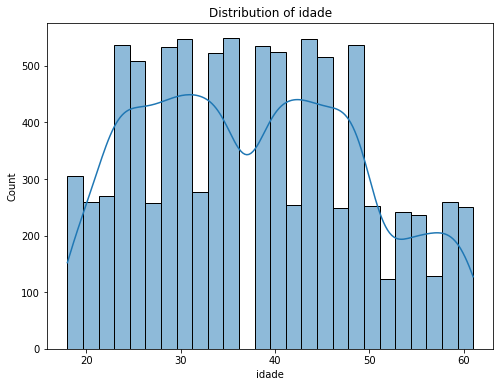

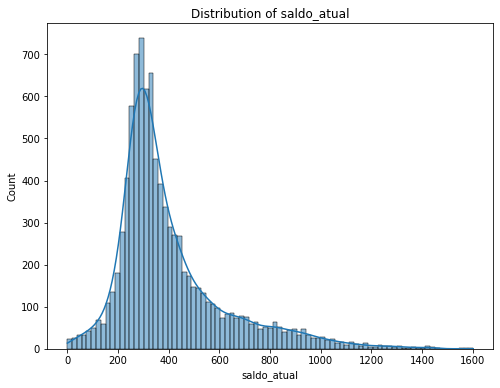

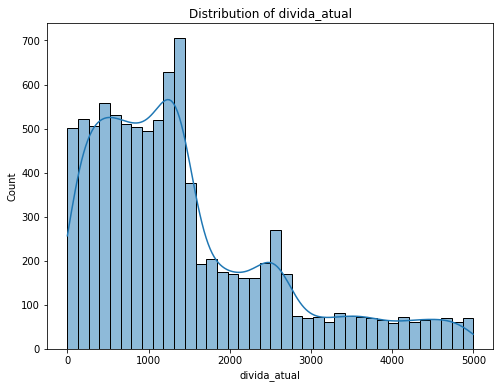

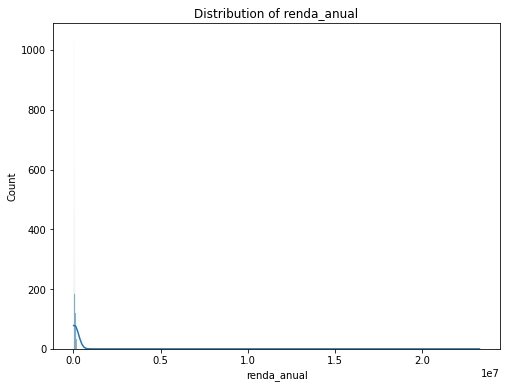

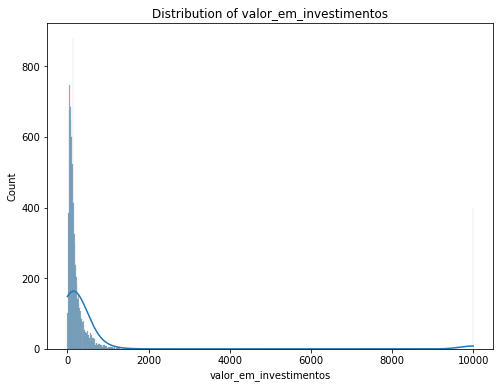

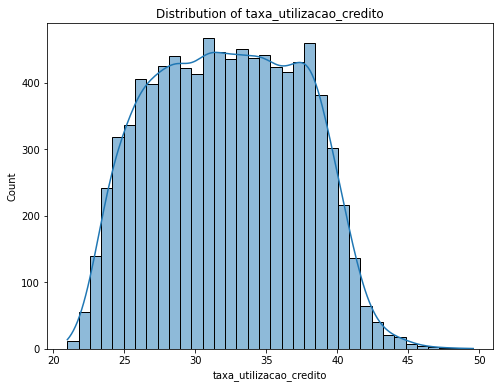

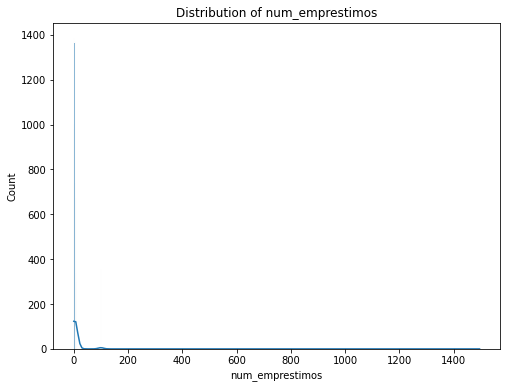

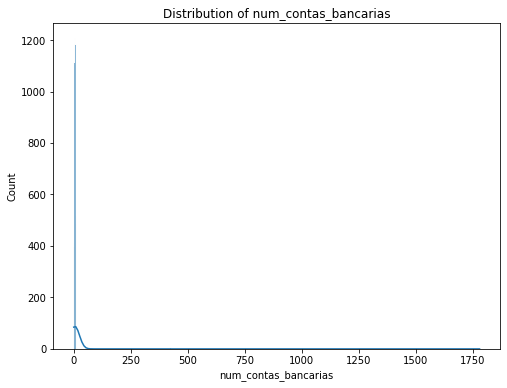

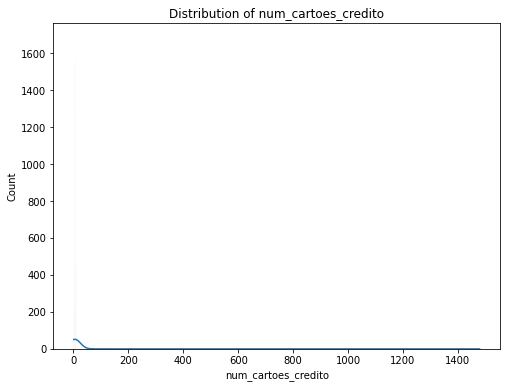

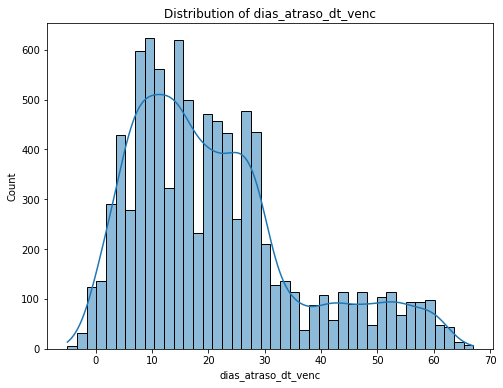

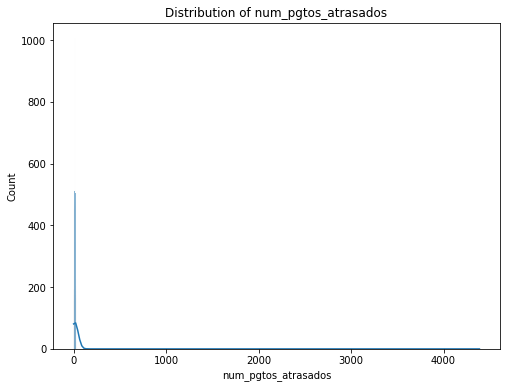

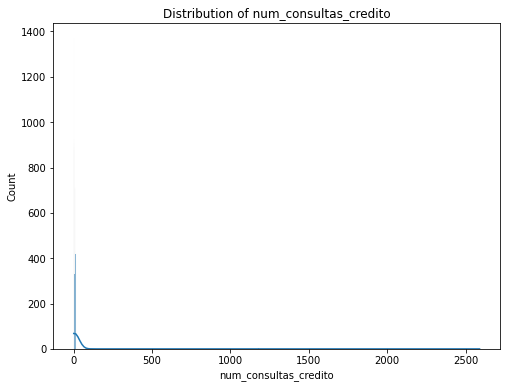

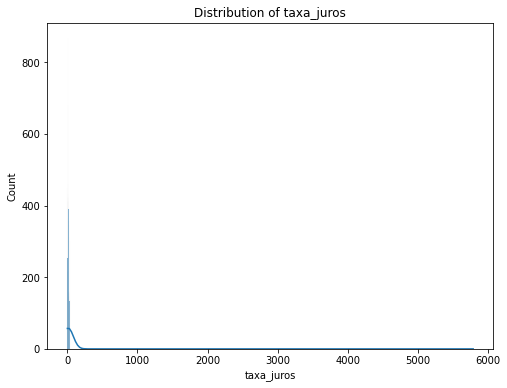

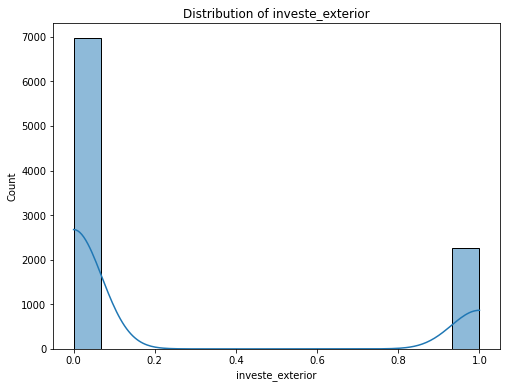

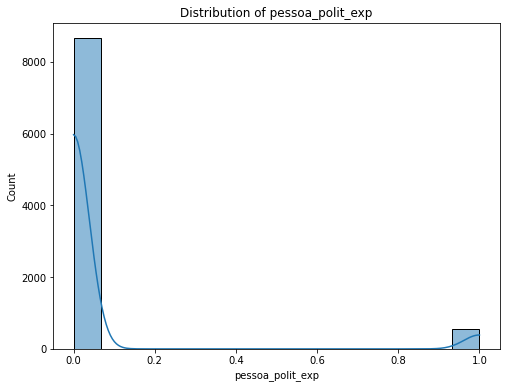

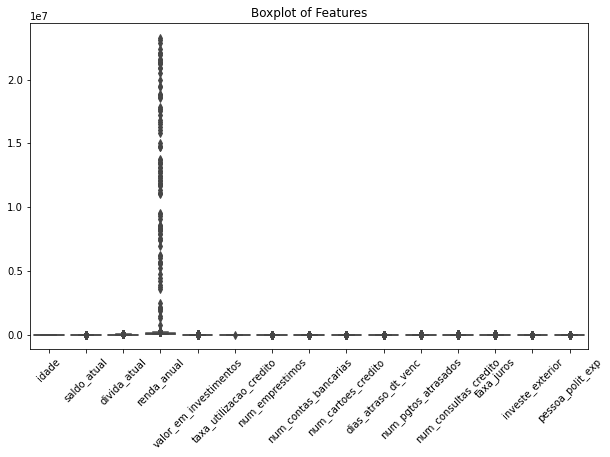

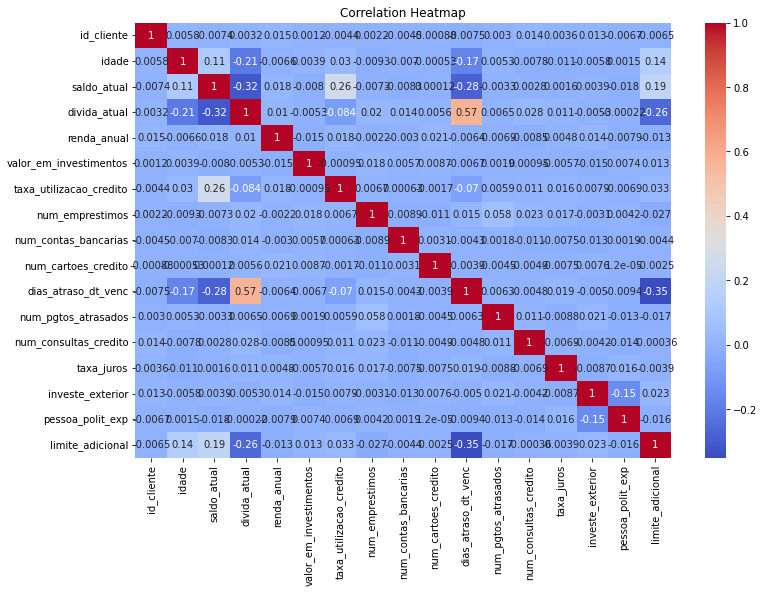

In [13]:
# Análise da distribuição das variáveis, presença de outliers e matriz de correlação
for column in df3.columns:
    if column not in ['id_cliente', 'limite_adicional']:
        plt.figure(figsize=(8, 6))
        sns.histplot(df3[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df3.drop(['id_cliente', 'limite_adicional'], axis=1))
plt.title('Boxplot of Features')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df3.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Processamento dos Dados

In [19]:
# Seleção de features com o método Boruta
boruta_selector = BorutaPy(
    estimator=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=3520),
    n_estimators='auto',
    verbose=2,
    random_state=3520
)
boruta_selector.fit(X_train.values, y_train.values)
X_train_selected = boruta_selector.transform(X_train.values)
X_test_selected = boruta_selector.transform(X_test.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	6
Iteration:

In [71]:
#Separando as colunas selecionadas
X_train_selected = boruta_selector.transform(X_train.values)
X_test_selected = boruta_selector.transform(X_test.values)

In [53]:
#Criando um dataframe com a classificação das variáveis pelo Boruta

ranking = boruta_selector.ranking_
ranking_df = pd.DataFrame({'Variável': X_train.columns, 'Ranking': ranking})
ranking_df.sort_values('Ranking', inplace=True)
print(ranking_df)

                   Variável  Ranking
7      num_contas_bancarias        1
8       num_cartoes_credito        1
9       dias_atraso_dt_venc        1
10      num_pgtos_atrasados        1
11    num_consultas_credito        1
12               taxa_juros        1
3               renda_anual        2
5   taxa_utilizacao_credito        3
1               saldo_atual        4
0                     idade        5
4    valor_em_investimentos        6
2              divida_atual        7
6           num_emprestimos        8
14         pessoa_polit_exp        8
13         investe_exterior       10


In [72]:
# Normalizar os dados numéricos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [73]:
# Codificar dados categóricos
label_encoder = LabelEncoder()
X_train_encoded = X_train_scaled.copy()
X_test_encoded = X_test_scaled.copy()

## Modeling

In [74]:
# Treinar o modelo
model_grb = GradientBoostingClassifier (ccp_alpha=0.0,
                                        criterion='friedman_mse', 
                                        init=None, 
                                        learning_rate=0.1, 
                                        loss='deviance', 
                                        max_depth= 3, 
                                        max_features= None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_samples_leaf=1, 
                                        min_samples_split=2, 
                                        min_weight_fraction_leaf=0.0, 
                                        n_estimators=100, 
                                        n_iter_no_change=None, 
                                        random_state=3520, 
                                        subsample=1.0, 
                                        tol=0.0001, 
                                        validation_fraction=0.1, 
                                        verbose=0, 
                                        warm_start=False)
#GradientBoostingClassifier(
  #  n_estimators=100, learning_rate=0.1, max_depth=3, random_state=3520
    
model_grb.fit(X_train_encoded, y_train)

# Prever no conjunto de teste
yhat_grb = model_grb.predict(X_test_encoded)

In [75]:
# Métricas e avaliação
print("Classification Report:\n", classification_report(y_test, yhat_grb))
print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_grb))

# Métricas F1 Score para diferentes médias
f1_macro = f1_score(y_test, yhat_grb, average='macro')
f1_micro = f1_score(y_test, yhat_grb, average='micro')
f1_weighted = f1_score(y_test, yhat_grb, average='weighted')

print(f"F1 Score (Macro): {f1_macro}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Weighted): {f1_weighted}")

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1942
           1       0.63      0.48      0.54       363

    accuracy                           0.87      2305
   macro avg       0.77      0.71      0.74      2305
weighted avg       0.86      0.87      0.87      2305

Confusion Matrix:
 [[1839  103]
 [ 189  174]]
F1 Score (Macro): 0.7350991813602015
F1 Score (Micro): 0.8733188720173536
F1 Score (Weighted): 0.8661795967041314


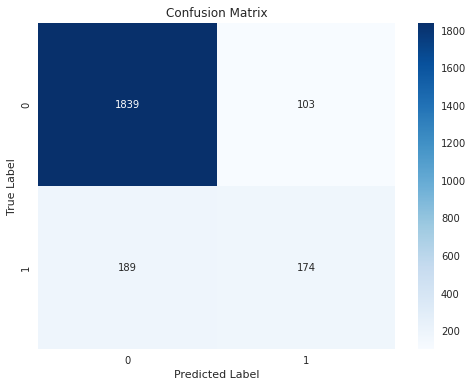

In [76]:
# Plotar Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, yhat_grb), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
# Use o PyCaret para ajuste de hiperparâmetros
clf1 = setup(data=pd.concat([X_train, y_train], axis=1), target='limite_adicional')
best_model = compare_models()

,Description,Value
0,Session id,7405
1,Target,limite_adicional
2,Target type,Binary
3,Original data shape,"(6915, 16)"
4,Transformed data shape,"(6915, 16)"
5,Transformed train set shape,"(4840, 16)"
6,Transformed test set shape,"(2075, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8764,0.9214,0.4218,0.6735,0.5173,0.4509,0.4679,0.5490
gbc,Gradient Boosting Classifier,0.8762,0.9232,0.4561,0.6560,0.5373,0.4686,0.4793,0.6350
catboost,CatBoost Classifier,0.8748,0.9208,0.4665,0.6434,0.5398,0.4696,0.4783,4.5840
ada,Ada Boost Classifier,0.8729,0.9165,0.4456,0.6392,0.5237,0.4533,0.4639,0.2970
lightgbm,Light Gradient Boosting Machine,0.8709,0.9177,0.4796,0.6167,0.5386,0.4650,0.4705,0.2870
xgboost,Extreme Gradient Boosting,0.8682,0.9132,0.4730,0.6052,0.5292,0.4542,0.4598,0.6580
et,Extra Trees Classifier,0.8593,0.8997,0.2672,0.6231,0.3727,0.3080,0.3436,0.4980
lr,Logistic Regression,0.8424,0.7330,0.0053,0.1083,0.0100,0.0070,0.0167,0.6150
ridge,Ridge Classifier,0.8424,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0360
dummy,Dummy Classifier,0.8424,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0480


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [28]:
#Tunando modelo com PyCaret
tuned_model = tune_model(model_grb)

#Criando variável com melhores parâmetros
best_params = tuned_model.get_params()
print(best_params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8802,0.9307,0.5065,0.6610,0.5735,0.5052,0.5113
1,0.8698,0.9197,0.4026,0.6458,0.4960,0.4258,0.4415
2,0.8822,0.9217,0.4026,0.7381,0.5210,0.4604,0.4880
3,0.8760,0.9190,0.3816,0.6905,0.4915,0.4275,0.4520
4,0.8905,0.9363,0.4342,0.7674,0.5546,0.4976,0.5239
5,0.8533,0.9003,0.3158,0.5581,0.4034,0.3270,0.3443
6,0.8926,0.9263,0.4211,0.8000,0.5517,0.4973,0.5304
7,0.8678,0.9164,0.3947,0.6250,0.4839,0.4124,0.4268
8,0.8781,0.9241,0.4342,0.6735,0.5280,0.4617,0.4764


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 3520, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Teste

In [77]:
# Preparar dados de teste para submissão
df_test = pd.read_csv(data_path + 'test.csv', low_memory=False)
df_test = df_test.drop(columns=['id_cliente'])
df_test['investe_exterior'] = df_test['investe_exterior'].apply(lambda x: 1 if x == 'Sim' else 0)
df_test['pessoa_polit_exp'] = df_test['pessoa_polit_exp'].apply(lambda x: 1 if x == 'Sim' else 0)
df_test_encoded = df_test.copy()

In [78]:
# Aplicar o método Boruta na base de teste
df_test_selected = boruta_selector.transform(df_test_encoded.values)

# Normalizar a base de teste selecionada
df_test_scaled = scaler.transform(df_test_selected)

# Fazer previsões no conjunto de teste usando o modelo treinado
predictions = model_grb.predict(df_test_scaled)

# Preparar submissão
df_submission = pd.read_csv(data_path + 'sample_submission.csv')
df_submission['limite_adicional'] = predictions
df_submission.to_csv('submission.csv', index=False)